In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

In [72]:
active_users_path = '/content/drive/MyDrive/web-analytics-synchuk/Active_Users.csv'
avg_session_duration_path = '/content/drive/MyDrive/web-analytics-synchuk/Avg_Session_Duration.csv'
page_views_path = '/content/drive/MyDrive/web-analytics-synchuk/Pageviews.csv'

active_users = pd.read_csv(active_users_path)
avg_session_duration = pd.read_csv(avg_session_duration_path)
page_views = pd.read_csv(page_views_path)

print(active_users.columns, avg_session_duration.columns, page_views.columns, sep='\n')

Index(['Day Index', '1 Day Active Users'], dtype='object')
Index(['Day Index', 'Avg. Session Duration'], dtype='object')
Index(['Day Index', 'Pageviews'], dtype='object')


In [73]:
dataframes = [active_users, avg_session_duration, page_views]
for df in dataframes:
    df['Day Index'] = pd.to_datetime(df['Day Index'], errors='coerce')

dataframes[1]['Avg. Session Duration'] = pd.to_timedelta(dataframes[1]['Avg. Session Duration'], errors='coerce')
dataframes[0]['1 Day Active Users'] = dataframes[0]['1 Day Active Users'].str.replace(',', '').astype(int, errors='ignore')
dataframes[2]['Pageviews'] = dataframes[2]['Pageviews'].str.replace(',','').astype(int, errors='ignore')

df = pd.merge(pd.merge(active_users, avg_session_duration, on=['Day Index']), page_views, on=['Day Index'])
df.rename(columns={'Day Index': 'Date'}, inplace=True)
df.drop(df.tail(1).index, inplace=True)

df.head()

<ipython-input-73-26ccaf49bb96>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Day Index'] = pd.to_datetime(df['Day Index'], errors='coerce')
<ipython-input-73-26ccaf49bb96>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Day Index'] = pd.to_datetime(df['Day Index'], errors='coerce')
<ipython-input-73-26ccaf49bb96>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Day Index'] = pd.to_datetime(df['Day Index'], errors='coerce')


,Date,1 Day Active Users,Avg. Session Duration,Pageviews
0,2021-05-01,1331,0 days 00:01:35,6194
1,2021-05-02,1429,0 days 00:01:12,6545
2,2021-05-03,2194,0 days 00:01:23,11755
3,2021-05-04,2399,0 days 00:01:03,11706
4,2021-05-05,2444,0 days 00:01:07,12171


In [48]:
df.shape

(395, 4)

In [74]:
def time_to_seconds(time_str) -> int:
    time_str = str(time_str)
    # print(time_str)
    days_part, _, time_part = time_str.split()
    # print(days_part, time_part)
    days = int(days_part)

    hours, minutes, seconds = map(int, time_part.split(':'))

    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds

    return total_seconds

# test = df['Avg. Session Duration'][0]
# time_to_seconds(test)

df['Avg. Session Duration'] = df['Avg. Session Duration'].apply(time_to_seconds)
df.head()

,Date,1 Day Active Users,Avg. Session Duration,Pageviews
0,2021-05-01,1331,95,6194
1,2021-05-02,1429,72,6545
2,2021-05-03,2194,83,11755
3,2021-05-04,2399,63,11706
4,2021-05-05,2444,67,12171


In [68]:
def plot_anomalies(series, anomalies, title):
    plt.figure(figsize=(15, 6))

    plt.plot(series, label='Data', color='black', linestyle='-', linewidth=1)
    plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies', marker='o', edgecolor='black', s=100, zorder=5)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()


def plot_combined_anomalies(series1, anomalies1, series2, anomalies2, title):
    plt.figure(figsize=(15, 6))

    plt.plot(series1, label='Sessions', color='red', alpha=0.7, linestyle='-', linewidth=1.5)
    plt.scatter(anomalies1.index, anomalies1, color='red', label='Sessions Anomalies', marker='x', edgecolor='black', s=100, zorder=5)

    plt.plot(series2, label='Users', color='blue', alpha=0.7, linestyle='-', linewidth=1.5)
    plt.scatter(anomalies2.index, anomalies2, color='blue', label='Users Anomalies', marker='o', edgecolor='black', s=100, zorder=5)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

<ipython-input-68-4a92628889bc>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(anomalies1.index, anomalies1, color='red', label='Sessions Anomalies', marker='x', edgecolor='black', s=100, zorder=5)


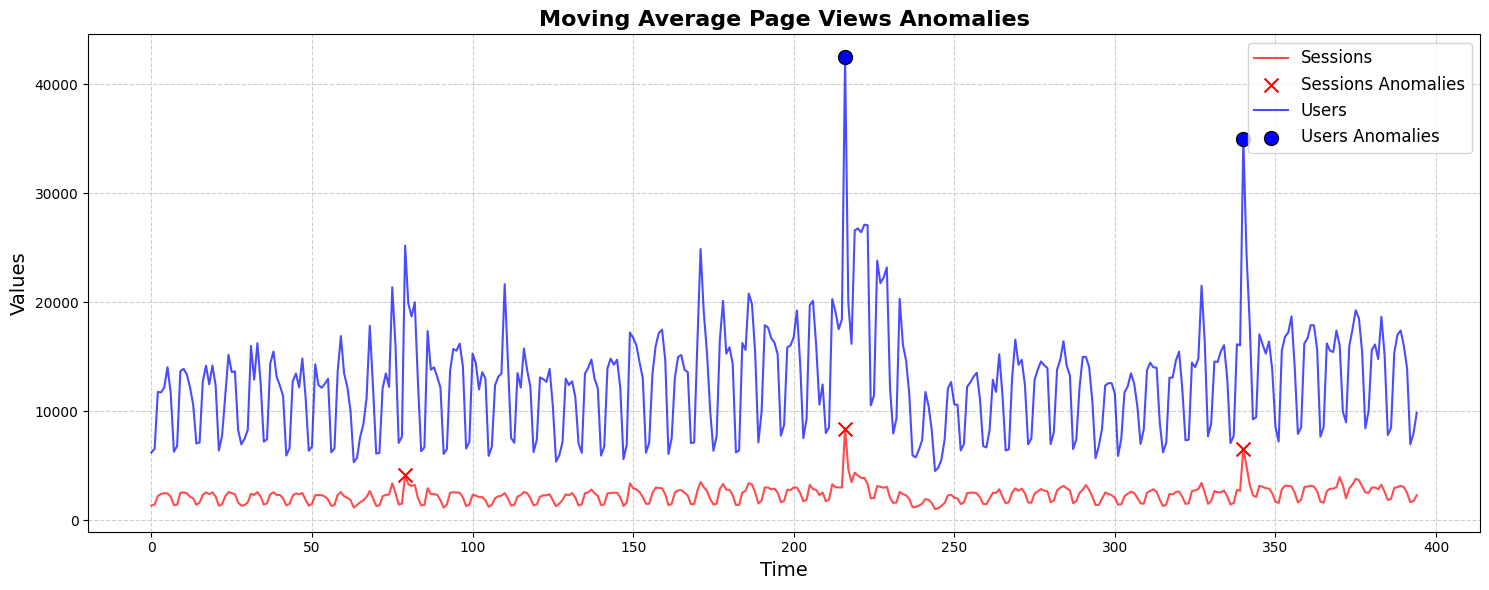

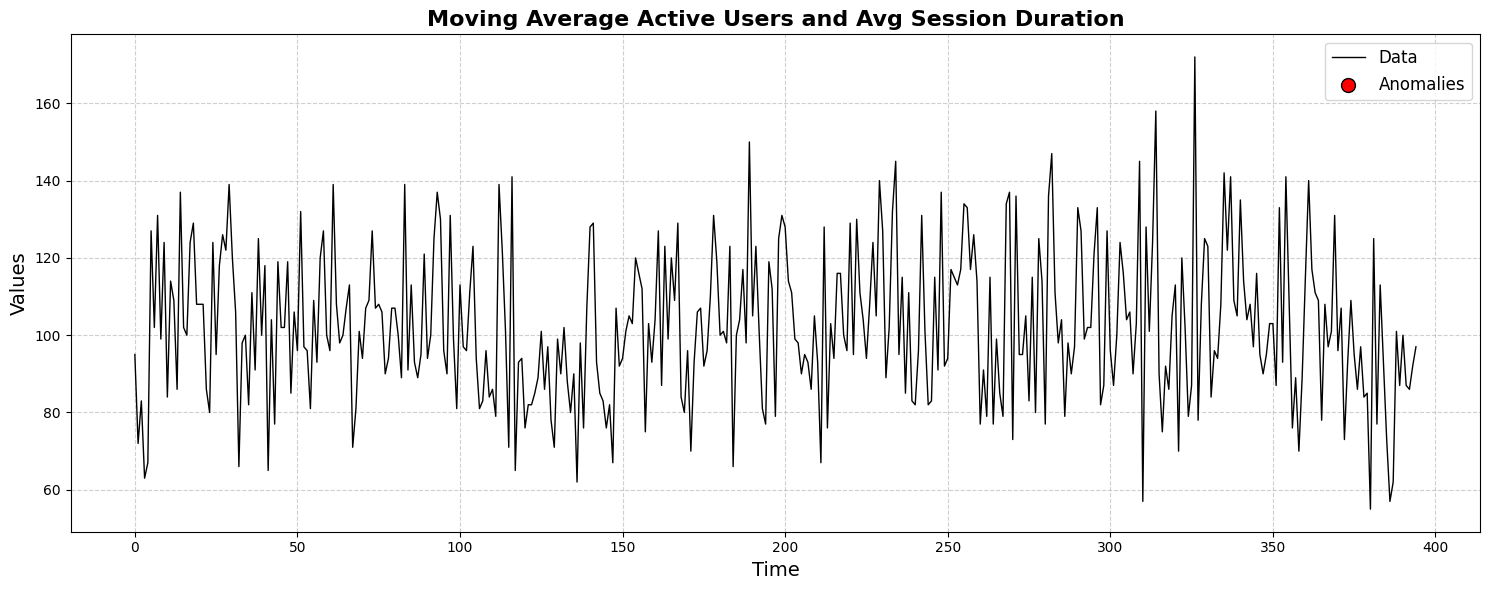

In [69]:
def moving_average_anomaly(series, window_size=30, threshold=3):
    rolling_mean = series.rolling(window=window_size).mean()
    rolling_std = series.rolling(window=window_size).std()
    anomalies = series[(series - rolling_mean).abs() > (threshold * rolling_std)]
    return anomalies

active_users_anomalies_ma = moving_average_anomaly(df['1 Day Active Users'])
avg_session_duration_anomalies_ma = moving_average_anomaly(df['Avg. Session Duration'])
page_views_anomalies_ma = moving_average_anomaly(df['Pageviews'])

plot_combined_anomalies(
    df['1 Day Active Users'], active_users_anomalies_ma,
    df['Pageviews'], page_views_anomalies_ma, 'Moving Average Page Views Anomalies'
)

plot_anomalies(df['Avg. Session Duration'], avg_session_duration_anomalies_ma, 'Moving Average Active Users and Avg Session Duration')


<ipython-input-68-4a92628889bc>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(anomalies1.index, anomalies1, color='red', label='Sessions Anomalies', marker='x', edgecolor='black', s=100, zorder=5)


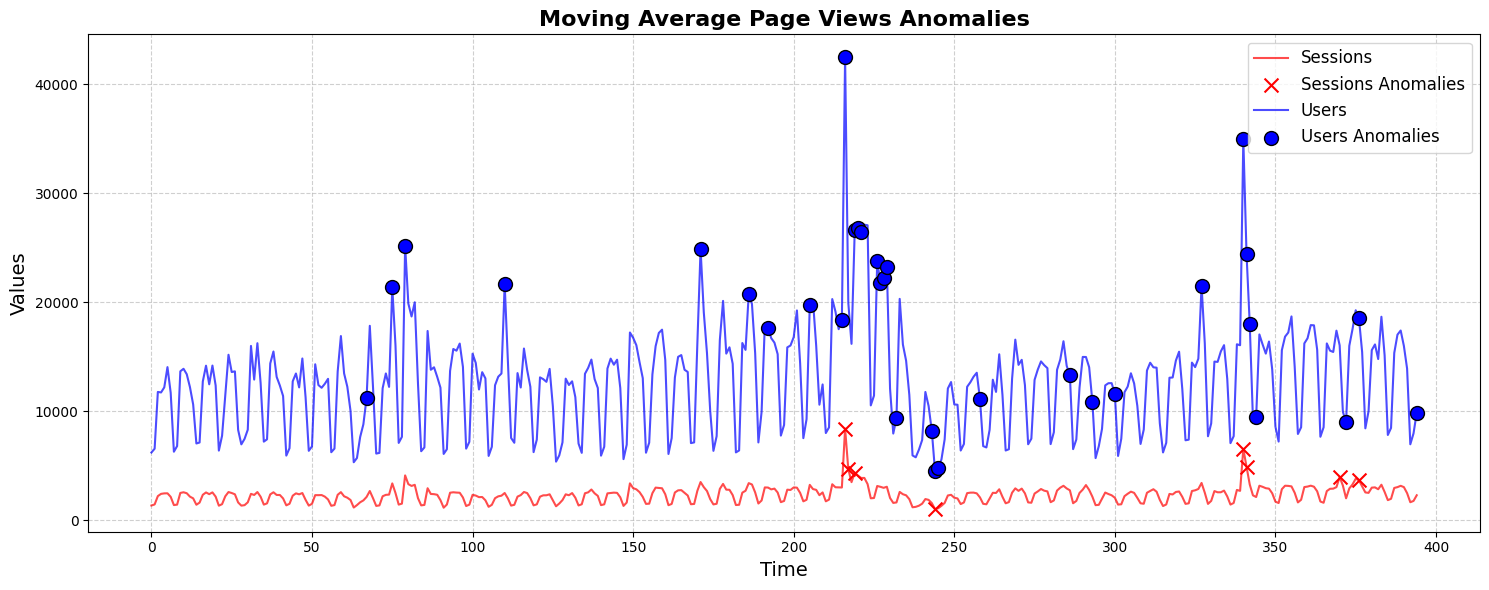

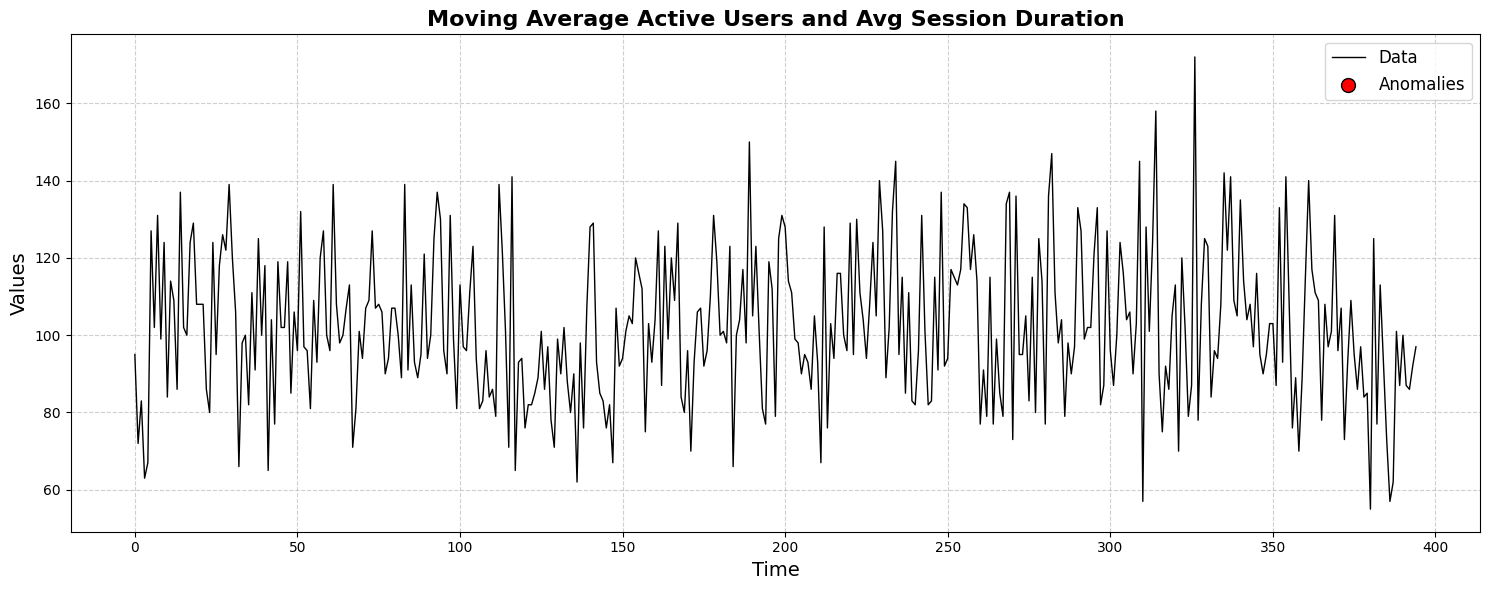

In [70]:
from sklearn.cluster import DBSCAN


def dbscan_anomaly(series, eps=75, min_samples=2):
    index = series.index
    series = series.values.reshape(-1, 1)
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(series)
    labels = model.labels_
    anomaly_series = pd.Series(labels, index=index)
    anomalies = series[anomaly_series == -1]
    return pd.Series(anomalies.flatten(), index=index[anomaly_series == -1])


active_users_anomalies_dbscan = dbscan_anomaly(df['1 Day Active Users'])
avg_session_duration_anomalies_dbscan = dbscan_anomaly(df['Avg. Session Duration'])
page_views_anomalies_dbscan = dbscan_anomaly(df['Pageviews'])

plot_combined_anomalies(
    df['1 Day Active Users'], active_users_anomalies_dbscan,
    df['Pageviews'], page_views_anomalies_dbscan, 'Moving Average Page Views Anomalies'
)

plot_anomalies(df['Avg. Session Duration'], avg_session_duration_anomalies_dbscan, 'Moving Average Active Users and Avg Session Duration')

<ipython-input-68-4a92628889bc>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(anomalies1.index, anomalies1, color='red', label='Sessions Anomalies', marker='x', edgecolor='black', s=100, zorder=5)


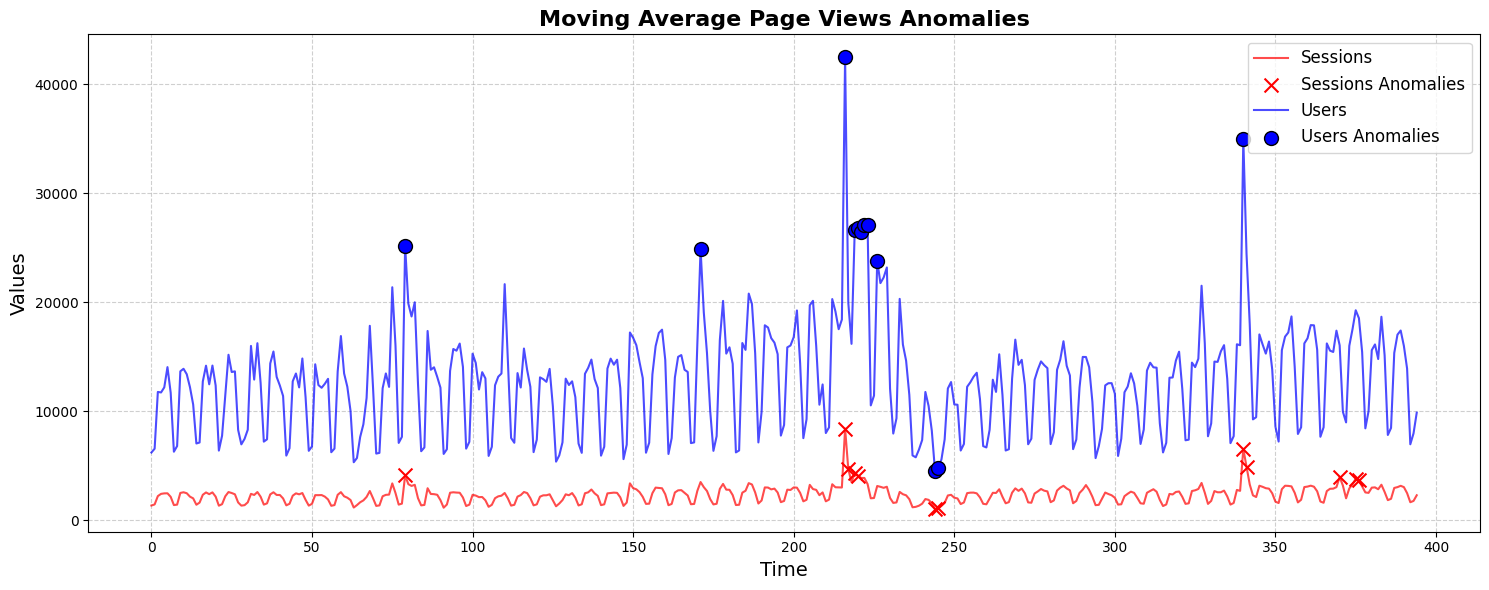

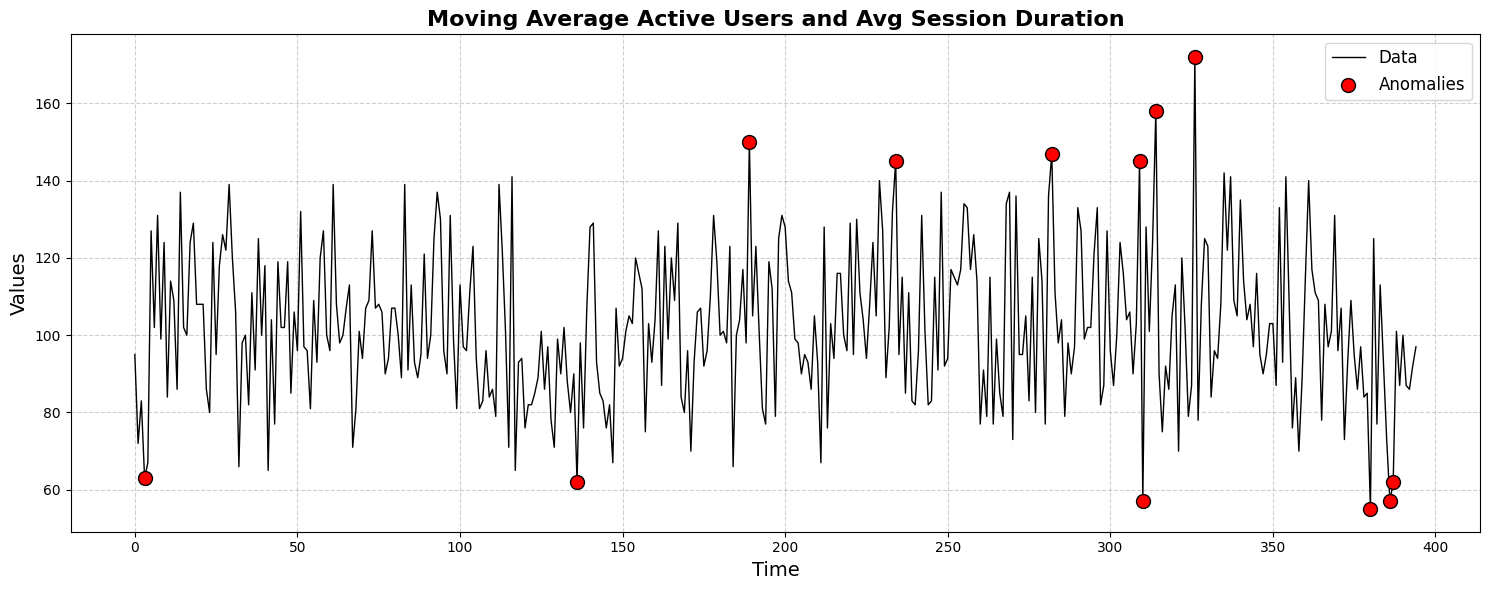

In [71]:
from sklearn.ensemble import IsolationForest


def isolation_forest_anomaly(series):
    index = series.index
    series = series.values.reshape(-1, 1)
    model = IsolationForest(contamination=0.03)
    model.fit(series)
    anomalies = model.predict(series)
    anomaly_series = pd.Series(anomalies, index=index)
    anomalies = series[anomaly_series == -1]
    return pd.Series(anomalies.flatten(), index=index[anomaly_series == -1])


active_users_anomalies_isolation_forest = isolation_forest_anomaly(df['1 Day Active Users'])
avg_session_duration_anomalies_isolation_forest = isolation_forest_anomaly(df['Avg. Session Duration'])
page_views_anomalies_isolation_forest = isolation_forest_anomaly(df['Pageviews'])

plot_combined_anomalies(
    df['1 Day Active Users'], active_users_anomalies_isolation_forest,
    df['Pageviews'], page_views_anomalies_isolation_forest, 'Moving Average Page Views Anomalies'
)

plot_anomalies(df['Avg. Session Duration'], avg_session_duration_anomalies_isolation_forest, 'Moving Average Active Users and Avg Session Duration')